# Realistic alternatives: Substituting the worst train connections with electrified highways.

## 1. Introduction
<!-- Introduces the problem and motivates your work --> 

Travel time is one of the most important factors in the decision for a mode of transportation.
This project aims to give insights into the extent of the advantage of travel by car over travel by train. 
Routes which are significantly faster by car are analysed with respect to their degree of electrification.
A suggestion for improvements to the charging infrastructure will be made. 
Infrastructure projects such as new railways take up years in planning and executing.
With the spirit of "free passage for free citizens" ("Freie Fahrt für freie Bürger"), a reasonable and at the same time 
environmentally friendly alternative is presented: choosing the fast and flexible travel by car, but opting for EVs instead of fossil fuels.

#### Main Question
Which routes between German cities are the fastest by car (in comparison to travel by train) and should be electrified 
for a "quick win" (compared to new train tracks) in climate action?

## 2. Methods
<!-- Describes which data sources you used and why, how you built your data pipeline and which data cleaning / transformation steps you followed as well as any problems encountered during data engineering -->
#### 2.1 Data Sources
The three data sources allow to firstly analyze the connectivity between cities and secondly, they allow for a judgement about the electrification of routes between cities.

<b>Datasource 1: Connectivity between largest German Cities ("Connectivity")</b>

This RDF-Star knowledge graph shows how well the 100 largest (by population) cities in Germany are connected.
It allows to compare travel by train, car and plane with respect to travel time. 

<b>Datasource 2: List of Electric Vehicle (EV) Charging Points in Germany ("Chargers")</b>

Registry of all publicly accessible charging points registered at the German authority for infrastructure (Bundesnetzagentur).
Contains information on location (address and coordinates) and charging point type/capacity.

<b>Datasource 3: EV Charging Point Infrastructure in Germany ("Development")</b>

This overview on the charging point infrastructure in Germany provides information on the number of charging points per federal state, city and district, as well as the historical evolution of the infrastructure.

#### 2.2 Data Pipelines
The project utilizes three different data pipelines, one for each data source.

<b>Data Pipeline 1: Connectivity</b>

The data is available as a knowledge graph. In the pipeline, the archived graph is downloaded, unpacked and serialized into a list of triples. Each triple is processed one at a time, where firstly, all triples which contain a formalization of a route are extracted. Secondly, all attributes describing the routes are extracted and both are matched in one tabular data structure. Thirdly, as some graph edges are not labelled in plain text, the labels of all edges are extracted from the graph and replace the data in the data table.
Finally, driving durations are converted to minutes and distances are converted to kilometers.

<b>Data Pipeline 2: Chargers</b>

The pipeline downloads a registry of all ev charging points in Germany. The data is available as a csv file. Firstly, the first rows, containing only a preamble, are removed. Then the column names of the table are replaced with English labels. Afterwards, geographic coordinated as well as the capacity of the chargers are saved as floating point values. Finally, completely empty rows are removed, and the data is saved.

<b>Data Pipeline 3: Development</b>

The data is published as an Excel sheet, where only one of several tables is relevant to this project. The relevant table and sheet range are selected and saved to a table. The table contains names of all districts, but in no uniform format. Therefore, all pre- and suffixes of district names are removed, to align the names with potential other datasets. For each district, the dataset contains quarterly counts of chargers, split into three categories of chargers (fast, regular and total). For this project, this is too fine-granular, so the number of total charging points in january of every year is selected from the table, and saved as the final dataset.

#### 2.3 Challenges

problems: the "landkreise" were ambiguously named: some contain "kreis" and some don't.
some metrics were just too expensive to calculate (ex. coverage %).

## 3. Results

In [1]:
%cd ..
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

/Users/lisaschmidt/Documents/GitHub/data-engineering-showcase


In [2]:
from project.route_processing import aggregate_travel_modes, calculate_absolute_deviation, calculate_relative_deviation, compute_connectivity_metrics

In [3]:
from project.geographical_visualizations import plot_routes_on_germany_map

### Comparing Train Travel to Travel by Car

In [4]:
cnx = sqlite3.connect('data/connections.sqlite')
df_connections = pd.read_sql_query("SELECT * FROM connections", cnx)
df_connections

,start,end,transport_type,route,duration,driving_distance
0,Bremerhaven,Marl,car,LINESTRING(8.586580000000001 53.55175000000000...,152,288.831379
1,Bremerhaven,Marl,train,None,320,NaN
2,Bremerhaven,Marl,train,None,385,NaN
3,Bremerhaven,Marl,train,None,322,NaN
4,Dortmund,Karlsruhe,car,"LINESTRING(7.46417 51.51505, 7.461770000000000...",200,355.366236
...,...,...,...,...,...,...
40510,Chemnitz,Osnabrück,train,None,320,NaN
40511,Halle (Saale),Bielefeld,car,LINESTRING(11.970030000000001 51.4824400000000...,180,344.566496
40512,Halle (Saale),Bielefeld,train,None,231,NaN
40513,Halle (Saale),Bielefeld,train,None,192,NaN


In [5]:
df_connectivity = aggregate_travel_modes(df_connections)
df_connectivity['absolute_deviation'] = df_connectivity.apply(calculate_absolute_deviation, axis=1)
df_connectivity['relative_deviation'] = df_connectivity.apply(calculate_relative_deviation, axis=1)
df_connectivity[["start", "end", "absolute_deviation", "relative_deviation"]].sort_values(by="relative_deviation")

,start,end,absolute_deviation,relative_deviation
1920,Erfurt,Marl,-196,-93.779904
5801,Marl,Erfurt,-194,-93.269231
4958,Leipzig,Marl,-181,-74.485597
3096,Halle (Saale),Marl,-163,-73.755656
5813,Marl,Halle (Saale),-160,-73.732719
...,...,...,...,...
646,Bottrop,Marl,298,1655.555556
3782,Herne,Marl,271,1806.666667
5820,Marl,Herne,305,1906.250000
7507,Recklinghausen,Marl,320,3200.000000


In [6]:
df_connectivity = pd.DataFrame(df_connectivity.iloc[:50])

In [7]:
cnx = sqlite3.connect('data/charging_points_germany.sqlite')
df_chargers = pd.read_sql_query("SELECT * FROM chargers", cnx)
df_chargers

,operator,city,state,district,latitude,longitude,rated_capacity
0,Albwerk GmbH & Co. KG,Heroldstatt,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.442398,9.659075,22.0
1,smopi,Heroldstatt,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.449353,9.672201,22.0
2,Albwerk GmbH & Co. KG,Westerheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.510500,9.609000,22.0
3,EnBW mobility+ AG und Co.KG,Amstetten,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.578534,9.874840,98.0
4,SWU Energie GmbH,Balzheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.179959,10.076977,22.0
...,...,...,...,...,...,...,...
54218,TEAG Mobil GmbH,Obertrebra,Thüringen,Landkreis Weimarer Land,51.060798,11.565503,300.0
54219,EnBW mobility+ AG und Co.KG,Apolda,Thüringen,Landkreis Weimarer Land,51.028940,11.517130,300.0
54220,EnBW mobility+ AG und Co.KG,Apolda,Thüringen,Landkreis Weimarer Land,51.028940,11.517130,300.0
54221,TEAG Mobil GmbH,Großheringen,Thüringen,Landkreis Weimarer Land,51.107188,11.659489,30.0


In [8]:
densities, distances = compute_connectivity_metrics(df_chargers, df_connectivity)

100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


In [9]:
df_connectivity['charger_density'] = densities
df_connectivity['avg_dist_charger'] = distances
df_connectivity[["start", "end", "charger_density", "avg_dist_charger"]][:5]

,start,end,charger_density,avg_dist_charger
0,Aachen,Augsburg,0.006888,1234.911463
1,Aachen,Berlin,0.005588,995.491315
2,Aachen,Bielefeld,0.006037,923.578395
3,Aachen,Bochum,0.008737,903.049892
4,Aachen,Bonn,0.009894,1110.329029


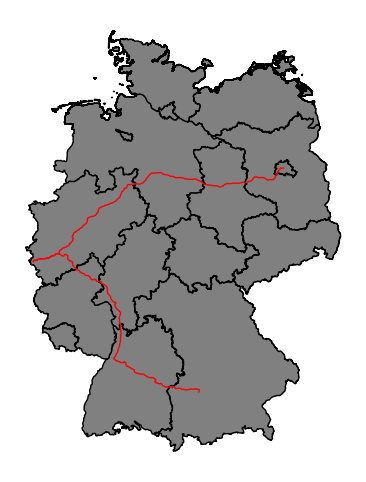

In [10]:
plot_routes_on_germany_map(df_connectivity[:2])

### EV Chargers in Germany

In [11]:
cnx = sqlite3.connect('data/charging_points_development.sqlite')
df_development = pd.read_sql_query("SELECT * FROM districts", cnx)

,chargers
state,
Bayern,17535
Nordrhein-Westfalen,15776
Baden-Württemberg,15531
Niedersachsen,8479
Hessen,6604
Schleswig-Holstein,3500
Sachsen,3449
Rheinland-Pfalz,3266
Berlin,2414


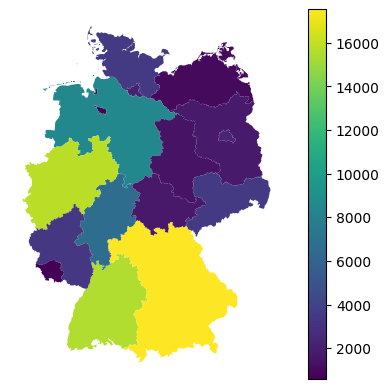

In [12]:
df_chargers_states = df_development[["state", "2023"]]
df_chargers_states = df_chargers_states.rename(columns={"2023":"chargers"})
df_chargers_states = df_chargers_states.groupby("state")["chargers"].sum()

import geopandas as gpd
df_states = gpd.read_file('./GER_shape/DEU_adm1.shp')
df_states = df_states.set_index('NAME_1')
df_states["chargers-2023"] = df_chargers_states

df_states.plot(column="chargers-2023", kind="geo", legend=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

pd.DataFrame(df_chargers_states).sort_values(by="chargers", ascending=False)

### Development of EV charging stations overall in Germany

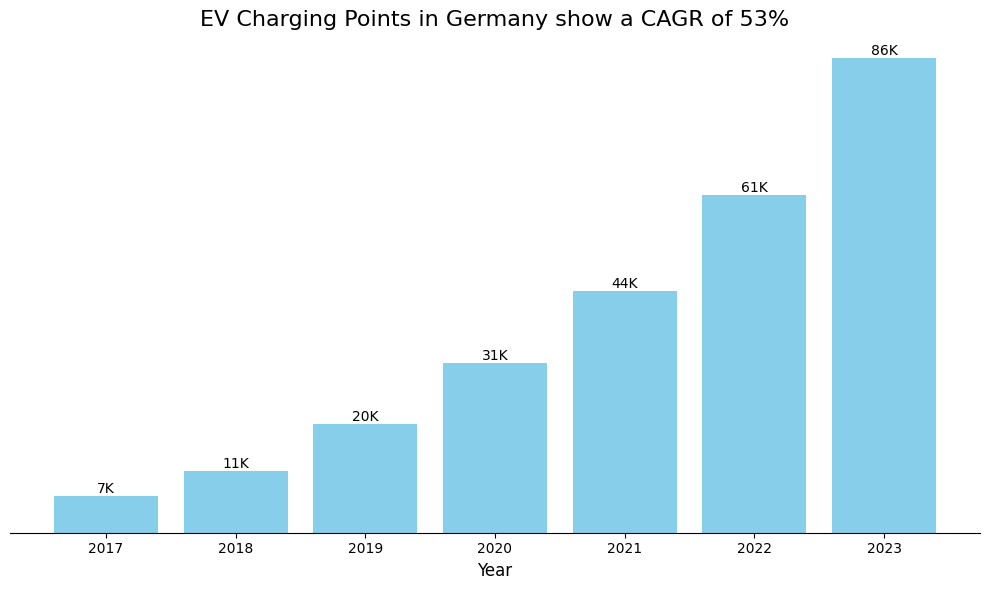

In [13]:
years = [str(d) for d in range(2017,2024)]
values = df_development.sum(axis=0)[2:]

plt.figure(figsize=(10, 6))
bars = plt.bar(years, values, color='skyblue')  # Use a professional color

plt.title('EV Charging Points in Germany show a CAGR of 53%', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Points', fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().yaxis.set_visible(False)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(int(round(yval/1000, 0)))+"K", 
             verticalalignment='bottom', horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

### Development of charging stations per district

In [14]:
cagr = ((df_development["2023"] / df_development["2020"]) ** (1 / 3) - 1) * 100
df_development["CAGR-3"] = cagr
df_development.sort_values(by="CAGR-3")[["location", "state", "CAGR-3"]][:5]

,location,state,CAGR-3
123,Regen,Bayern,-5.940289
132,Straubing-Bogen,Bayern,6.917811
211,Friesland,Niedersachsen,9.204330
160,Bremerhaven,Bremen,10.064242
158,Uckermark,Brandenburg,11.804676


In [15]:
df_development.sort_values(by="CAGR-3")[["location", "state", "CAGR-3"]][-5:]

,location,state,CAGR-3
42,Stuttgart,Baden-Württemberg,131.090655
171,Groß-Gerau,Hessen,132.587532
313,Cochem-Zell,Rheinland-Pfalz,149.331548
155,Prignitz,Brandenburg,151.984210
189,Schwerin,Mecklenburg-Vorpommern,233.222185


NAME_1
Saarland                  70.064454
Mecklenburg-Vorpommern    69.500122
Brandenburg               54.972203
Baden-Württemberg         46.882587
Hessen                    45.541177
Sachsen                   44.116820
Rheinland-Pfalz           42.932372
Bayern                    42.505295
Nordrhein-Westfalen       41.795339
Niedersachsen             40.807948
Schleswig-Holstein        38.877050
Sachsen-Anhalt            38.403632
Thüringen                 35.770980
Berlin                    33.482318
Hamburg                   22.102430
Bremen                    20.678124
Name: CAGR-3, dtype: float64

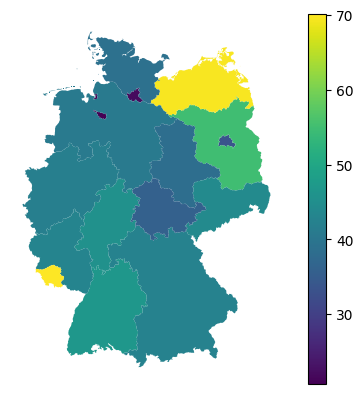

In [16]:
df_states["CAGR-3"] = df_development.groupby("state")["CAGR-3"].mean()

df_states.plot(column="CAGR-3", kind="geo", legend=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

pd.DataFrame(df_states).sort_values(by="CAGR-3", ascending=False)["CAGR-3"]

### ...

### Best routes for taking a train

### Are the worst routes electrified?
calculate the longest distance without a charger

## Discussion